# Example of analysis of WHALES output for SWOT

In [1]:
import sys
PATH_with_functions = 'WHALES_TUM/src'
sys.path.append(PATH_with_functions)
from altimeters_parameters import alti_read_l2lr,alti_read_l2hrw,alti_read_l2hrw_ccidebug,alti_read_l2hrw_cci

import netCDF4
from netCDF4 import Dataset

import numpy as np
import xarray as xr

# --- plotting and interactive stuff ----------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import fftconvolve

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})


import matplotlib.pyplot as plt
import scipy.io
import os
import pathlib

import time


## 1. Reading a GDR file and making some basic plots to know where the data is 

Text(0.5, 0, 'latitude')

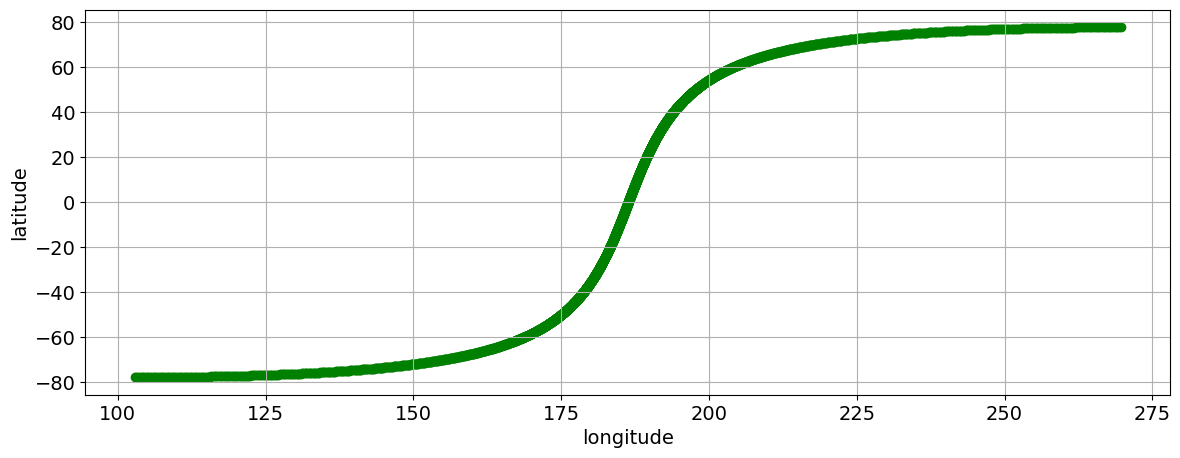

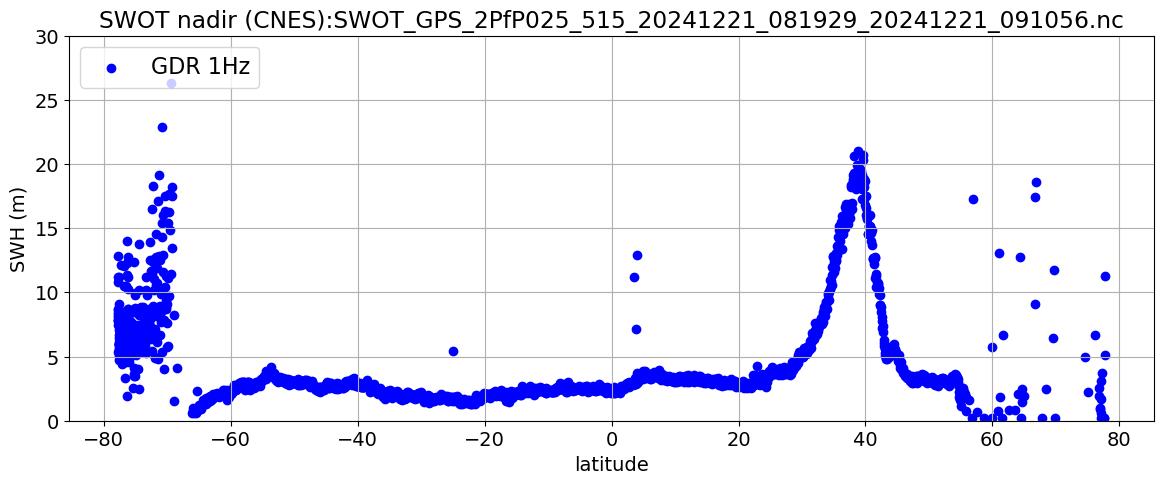

In [2]:
mission='swot'
file="SWOT_GPS_2PfP025_515_20241221_081929_20241221_091056.nc"


Sgd=alti_read_l2lr(mission,file)


inds=np.where((np.isfinite(Sgd.swh_1hz)==1))[0]  # &  (S_landmask==0))[0]

fig,axs = plt.subplots(1,1,figsize=(14,5))
ax = axs
im=ax.scatter(Sgd.lon_1hz[inds],Sgd.lat_1hz[inds],c='g',label='GDR')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')


fig,axs = plt.subplots(1,1,figsize=(14,5))
ax = axs
im=ax.scatter(Sgd.lat_1hz[inds],Sgd.swh_1hz[inds],c='b',label='GDR 1Hz')
ax.legend(loc='upper left', fontsize=16)
ax.set_ylim([0,30])
#ax.set_xlim(lat_bounds) 
ax.set_ylabel('SWH (m)')
ax.set_title('SWOT nadir (CNES):'+file)
ax.set_xlabel('latitude')


latitudes of selected index: 38.850414 38.909244  median SWH: 20.9345 , flags: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


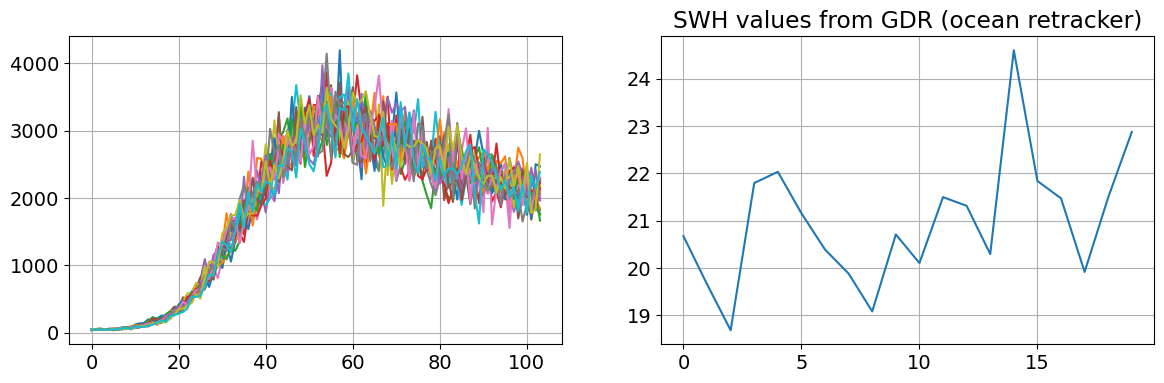

In [3]:
#Now we look at some waveforms ... 
Sg2d=alti_read_l2hrw(mission,file)

fig,axs = plt.subplots(1,2,figsize=(14,4))
ax = axs[0]
#print(Sg2d)
ind=2020
print('latitudes of selected index:',Sg2d.lat2d[ind,0].values,Sg2d.lat2d[ind,-1].values,' median SWH:',np.nanmedian(Sg2d.swh2d[ind,:]),', flags:',Sg2d.flag2d[ind,:].values)
im=ax.plot(Sg2d.waveforms[ind,:,:].T)
ax = axs[1]
im=ax.plot(Sg2d.swh2d[ind,:])
ax.set_title('SWH values from GDR (ocean retracker)')

ax.grid(True)

##  2. Now we look at our WHALES-retracked results

In [13]:
# the files TEST* were obtained as follows:  
#                              the -d 1 parameter is there to add the weights and normalized waveforms in the output):
#                              the -w 2 is to compute theoretical weights from the Brown waveform (no weight file is available for SWOT) 
#
# conda activate seastatecci_whales
# python WHALES_TUM/src/python_WHALES_launcher.py -m swot -i SWOT_GPS_2PfP025_515_20241221_081929_20241221_091056.nc -d 1 -w 2  -o TEST_v5b
# python WHALES_TUM/src/python_WHALES_launcher.py -m swot -i SWOT_GPS_2PfP025_515_20241221_081929_20241221_091056.nc -d 1 -w 2 -s 3 -o TEST_v5b_s3

tag1='v5c'  
tag2='v5b'  
tag3='v5b_s3'


fileg='/home/ardhuin/PUBLI/2025_SWOTgroups/'+file
file1='TEST_'+tag1+'/'+file      
file2='TEST_'+tag2+'/'+file  
file3='TEST_'+tag3+'/'+file  


Sg =alti_read_l2hrw('swot',fileg)
S1 =alti_read_l2hrw_ccidebug('swot',file1)
S2 =alti_read_l2hrw_ccidebug('swot',file2)


filename; TEST_v5c/SWOT_GPS_2PfP025_515_20241221_081929_20241221_091056.nc
filename; TEST_v5b/SWOT_GPS_2PfP025_515_20241221_081929_20241221_091056.nc


lat bounds: 30.012828 30.015953 30.019078 35.620579
median std: 0.5079, 0.3050,0.3050
median std: 0.6860, 0.4402,0.4365
median std: 0.7418, 0.5135,0.5126
39N min std: 1.0171, 0.6983,0.7595


/home/ardhuin/miniconda3/envs/OPTOOLS/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/ardhuin/miniconda3/envs/OPTOOLS/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


S1: (2802, 20, 104) ## [15.188115 17.293077 17.977634 16.414516 18.90937  17.652828 19.156261
 19.870539 19.901201 21.20995  21.432724 21.494122 21.213182 20.16728
 21.119038 20.799063 20.367275 20.152466 21.395653 21.493671]
S2: (2802, 20, 104) ## [14.952691   16.5462     15.9845495  16.054337   18.84132    15.85899
 19.144255   -0.915831   -0.9615263  21.76399    21.997183   -0.93815136
 21.415842   20.455437   21.002918   19.943378   20.300192   20.55413
 21.366497   21.37063   ]


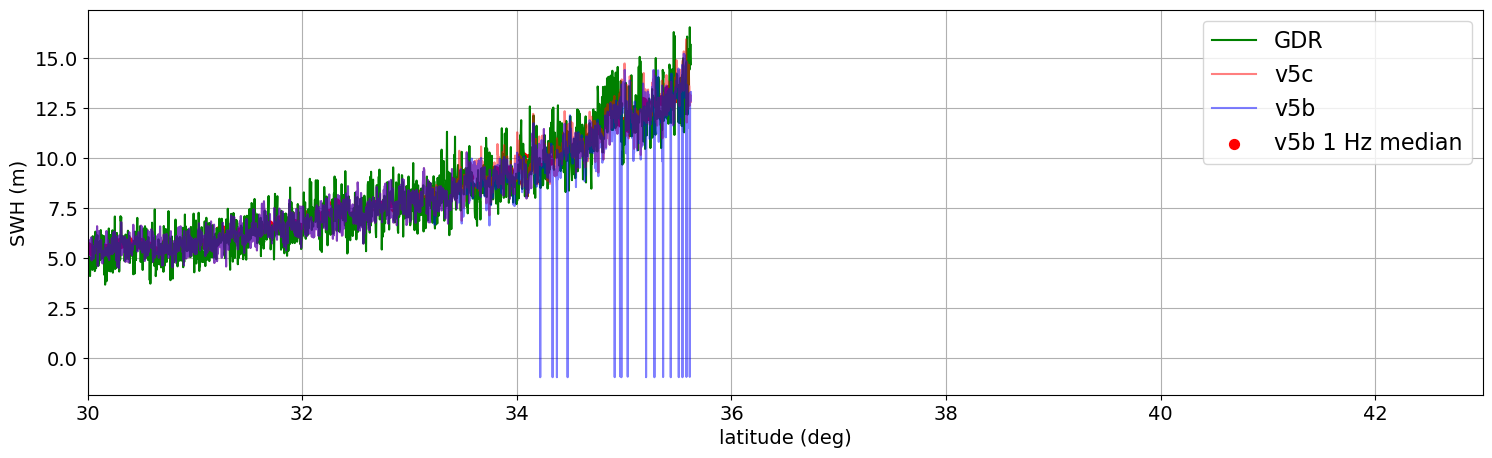

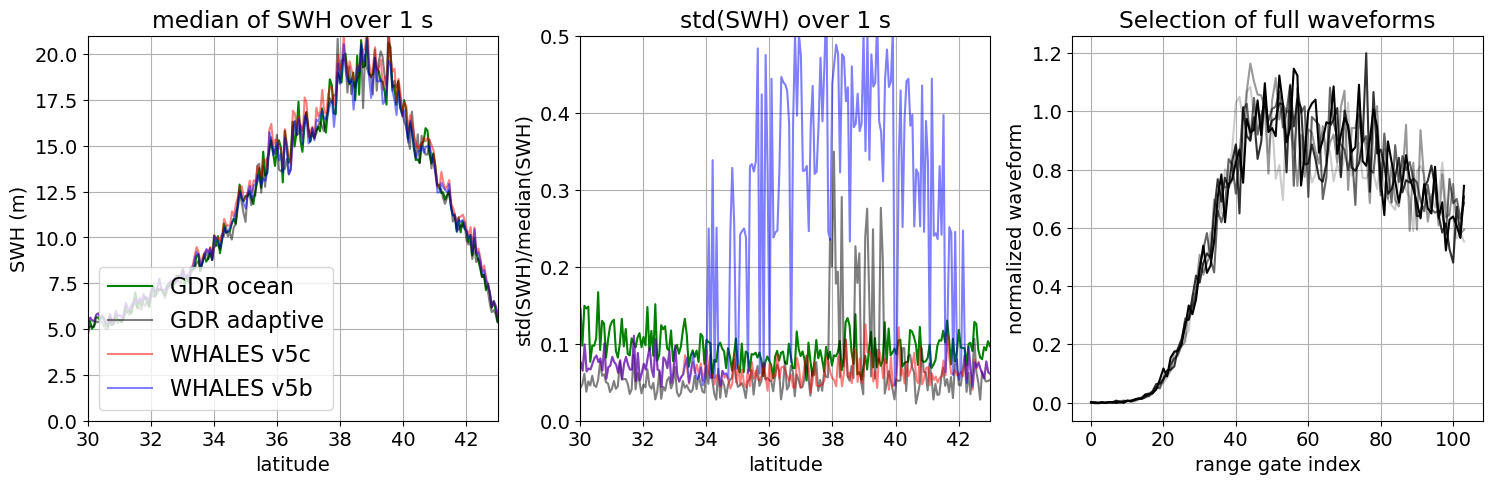

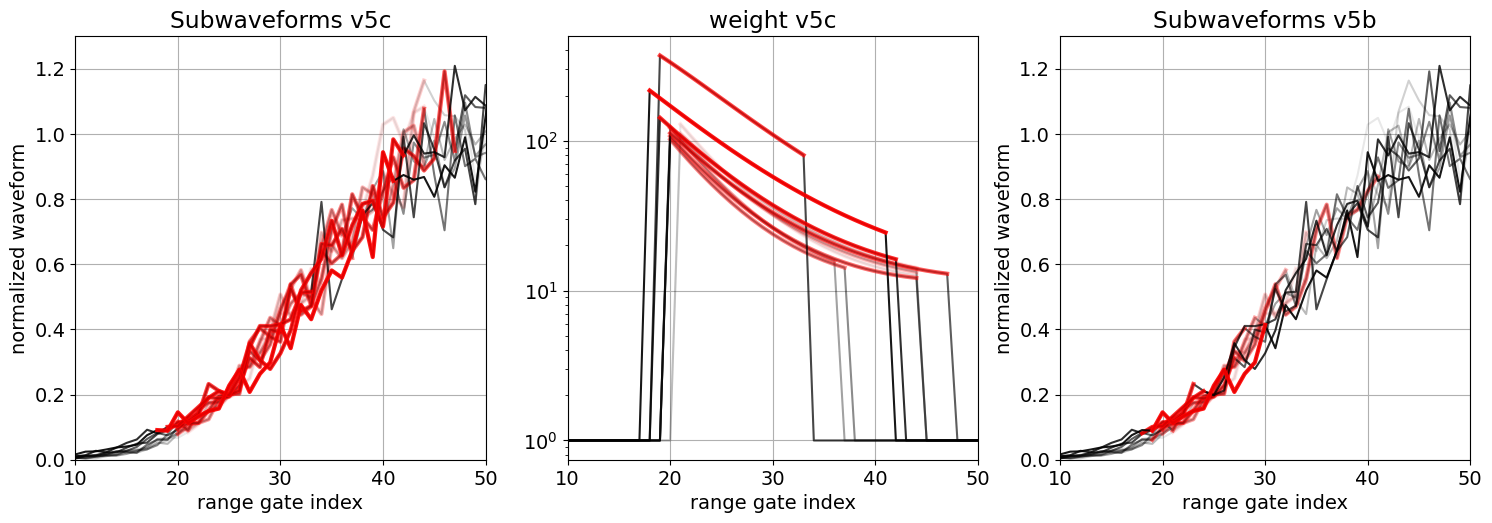

In [15]:
ds_sgdr= netCDF4.Dataset(file, 'r')
Hs0=ds_sgdr.groups['data_20'].groups['ku'].variables['swh_adaptive'][:]
time1 = np.ma.getdata(ds_sgdr['data_01'].variables['time'][:])
nhf=20;n1=len(time1)
nall=len(Hs0)
nlr=nall//nhf
nal=nlr*nhf
Hsa=np.reshape(Hs0[0:nal], (nlr,nhf))

latr=[30,43]
#latr=[20,40]

inds=np.where(Sg.lat2d[:,0] >latr[0])[0][0:90]

fig,axs = plt.subplots(1,1,figsize=(18,5))
ax = axs

latss=Sg.lat2d[inds,:].values.flatten()
print('lat bounds:',latss[0],latss[1],latss[2],latss[-1])
im=ax.plot(latss,Sg.swh2d[inds,:].values.flatten(),c='g',label='GDR')
#im=ax.plot(latss,Hsi2[inds,:].flatten(),c='k',label='tag0')
im=ax.plot(latss,S1.swh2d[inds,:].values.flatten(),c='r',alpha=0.5,label=tag1)
im=ax.plot(latss,S2.swh2d[inds,:].values.flatten(),c='b',alpha=0.5,label=tag2)
im=ax.scatter(S2.lat2d[inds,10],np.median(S2.swh2d[inds,:],axis=1),c='r',s=50,label=tag2+' 1 Hz median')
ax.legend(loc='upper right', fontsize=16)
ax.set_ylabel('SWH (m)')
ax.set_xlabel('latitude (deg)')
ax.set_xlim(latr)



inds=np.where(np.abs(S1.lat2d[:,0]-20) < 10)[0]
print(f"median std: {np.nanmedian(np.nanstd(Sg.swh2d[inds,:],axis=1)):.4f}, {np.nanmedian(np.nanstd(S1.swh2d[inds,:],axis=1)):.4f},{np.nanmedian(np.nanstd(S2.swh2d[inds,:],axis=1)):.4f}" )

inds=np.where(np.abs(S1.lat2d[:,0]-30) < 10)[0]
print(f"median std: {np.nanmedian(np.nanstd(Sg.swh2d[inds,:],axis=1)):.4f}, {np.nanmedian(np.nanstd(S1.swh2d[inds,:],axis=1)):.4f},{np.nanmedian(np.nanstd(S2.swh2d[inds,:],axis=1)):.4f}" )

inds=np.where(np.abs(S1.lat2d[:,0]-40) < 10)[0]
print(f"median std: {np.nanmedian(np.nanstd(Sg.swh2d[inds,:],axis=1)):.4f}, {np.nanmedian(np.nanstd(S1.swh2d[inds,:],axis=1)):.4f},{np.nanmedian(np.nanstd(S2.swh2d[inds,:],axis=1)):.4f}" )


inds=np.where(np.abs(S1.lat2d[:,0]-39) < 1)[0]
print(f"39N min std: {np.nanmin(np.nanstd(Sg.swh2d[inds,:],axis=1)):.4f}, {np.nanmin(np.nanstd(S1.swh2d[inds,:],axis=1)):.4f},{np.nanmin(np.nanstd(S2.swh2d[inds,:],axis=1)):.4f}" )


fig,axs = plt.subplots(1,3,figsize=(18,5))
ax = axs[0]
im=ax.plot(Sg.lat2d[:,0],np.median(Sg.swh2d[:,:],axis=1),c='g',label='GDR ocean')
im=ax.plot(Sg.lat2d[:,0],np.median(Hsa[:,:],axis=1),c='k',alpha=0.5,label='GDR adaptive')
im=ax.plot(S2.lat2d[:,0],np.median(S1.swh2d[:,:],axis=1),c='r',alpha=0.5,label='WHALES '+tag1)
im=ax.plot(S2.lat2d[:,0],np.median(S2.swh2d[:,:],axis=1),c='b',alpha=0.5,label='WHALES '+tag2)
ax.set_ylim((0,21))
ax.set_title('median of SWH over 1 s')
ax.set_ylabel('SWH (m)')
ax.set_xlabel('latitude')
ax.set_xlim(latr)
ax.legend(loc='lower left', fontsize=16)

ax = axs[1]
im=ax.plot(Sg.lat2d[:,0],np.nanstd(Sg.swh2d[:,:],axis=1)/np.median(Sg.swh2d[:,:],axis=1),c='g',label='GDR')
im=ax.plot(Sg.lat2d[:,0],np.nanstd(Hsa,axis=1)/np.median(Hsa[:,:],axis=1),c='k',alpha=0.5,label='GDR adaptive')
im=ax.plot(S2.lat2d[:,0],np.nanstd(S1.swh2d[:,:],axis=1)/np.median(S1.swh2d[:,:],axis=1),c='r',alpha=0.5,label='WHALES '+tag1)
im=ax.plot(S2.lat2d[:,0],np.nanstd(S2.swh2d[:,:],axis=1)/np.median(S2.swh2d[:,:],axis=1),c='b',alpha=0.5,label='WHALES '+tag2)
ax.set_ylim((0,0.5))
ax.set_title('std(SWH) over 1 s')
ax.set_ylabel('std(SWH)/median(SWH)')
ax.set_xlabel('latitude')
ax.set_xlim(latr)
#inds=np.where(S1.lat2d[:,0] >49)[0]
#ind=inds[0]
ind=2020
ax = axs[2]

nt=5
x=np.arange(0,104,1)
for k in range(nt):
    im=ax.plot(x,S2.normalized_waveform[ind,k,:],c='k',alpha=(k+1)/nt)
axs[2].set_title('Selection of full waveforms')
axs[2].set_xlabel('range gate index')
axs[2].set_ylabel('normalized waveform')
fig.savefig('J2_Kirin_swh_waveforms.pdf')


fig,axs = plt.subplots(1,3,figsize=(18,5.5))
ax = axs[0]


print('S1:',np.shape(S2.normalized_waveform),'##',S1.swh2d[ind,:].values)
print('S2:',np.shape(S2.normalized_waveform),'##',S2.swh2d[ind,:].values)

nt=10
for k in range(nt):
    #im=ax.plot(S2.normalized_waveform[ind,k,:])
    ax = axs[0]
    i1=int(S1.startgate_WHALES[ind,k])
    i2=int(S1.endgate_WHALES[ind,k])
    im=ax.plot(x,S1.normalized_waveform[ind,k,:],c='k',alpha=(k+1)/(nt+1))
    im=ax.plot(x[i1:i2],S1.normalized_waveform[ind,k,i1:i2],c='r',alpha=(k+1)/(nt+1),linewidth=3)
    ax = axs[1]
    im=ax.semilogy(x,S1.weights[ind,k,:],c='k',alpha=(k+1)/(nt+1))
    im=ax.semilogy(x[i1:i2],S1.weights[ind,k,i1:i2],c='r',alpha=(k+1)/(nt+1),linewidth=3)
    ax = axs[2]
    i1=int(S2.startgate_WHALES[ind,k])
    i2=int(S2.endgate_WHALES[ind,k])
    im=ax.plot(x,S2.normalized_waveform[ind,k,:],c='k',alpha=(k+1)/(nt+1))
    im=ax.plot(x[i1:i2],S2.normalized_waveform[ind,k,i1:i2],c='r',alpha=(k+1)/(nt+1),linewidth=3)
axs[0].set_title('Subwaveforms '+tag1)
axs[0].set_xlabel('range gate index')
axs[0].set_ylabel('normalized waveform')
axs[2].set_title('Subwaveforms '+tag2)
axs[2].set_xlabel('range gate index')
axs[2].set_ylabel('normalized waveform')
axs[1].set_title('weight '+tag1)
axs[1].set_xlabel('range gate index')
#axs[1].set_ylabel('weight')
axs[1].set_xlim(10,50)

axs[0].set_ylim(0.,1.3)
axs[0].set_xlim(10,50)


axs[2].set_ylim(0.,1.3)
axs[2].set_xlim(10,50)


fig.savefig('SWOT_Eddie_subwaveforms_TEST'+tag2+'.pdf')



In [12]:
print(1.5705/20,1.01/19)
print('rhoc/2=',np.sqrt(2*20*891E3))
print('Qkk estimated from DC-A2024 eq. 20):', 1.57/np.sqrt(20)/4.2*np.sqrt(891E3))

0.078525 0.053157894736842105
rhoc/2= 5969.92462263972
Qkk estimated from DC-A2024 eq. 20): 78.89949367417269


In [98]:
print((8)*4*24*51/86400)

0.4533333333333333


In [102]:
print(95*8*51/86400)

0.4486111111111111
